In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from typing import Union

Reading and displaying the original MRI image

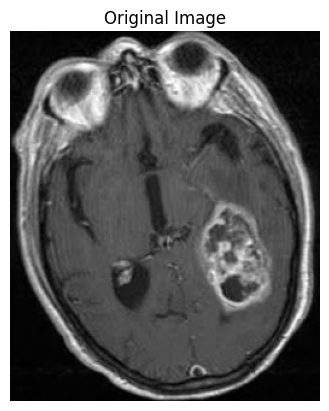

In [15]:
img = cv2.imread('images/meninglioma.jpg', cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError("Image not found. Please provide a valid path.")

plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

Thresholding

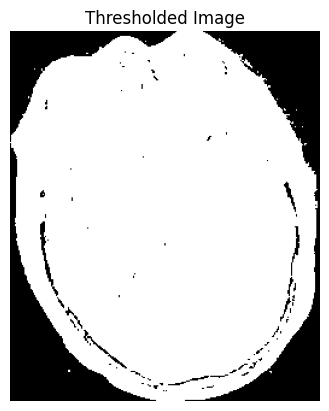

In [16]:
_, binary_img = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)

plt.imshow(binary_img, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')
plt.show()

To remove the skull, we do the following steps:

1. Dilation
2. Erosion
3. Applying this as a mask to the original image

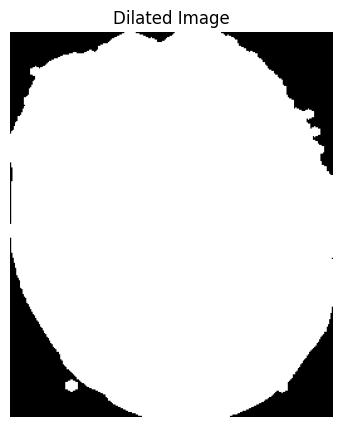

In [17]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
dilated_img = cv2.dilate(binary_img, kernel, iterations=2)

plt.figure(figsize=(5, 5))
plt.imshow(dilated_img, cmap='gray')
plt.title('Dilated Image')
plt.axis('off')
plt.show()


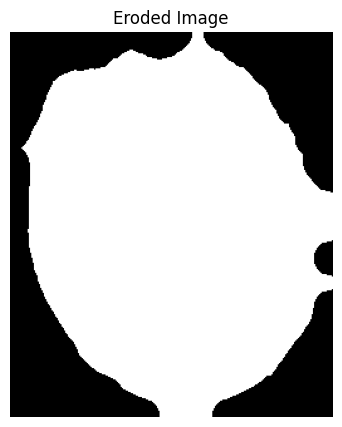

In [18]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
eroded_img = cv2.erode(dilated_img, kernel, iterations=2)

plt.figure(figsize=(5, 5))
plt.imshow(eroded_img, cmap="gray")
plt.title("Eroded Image")
plt.axis("off")
plt.show()

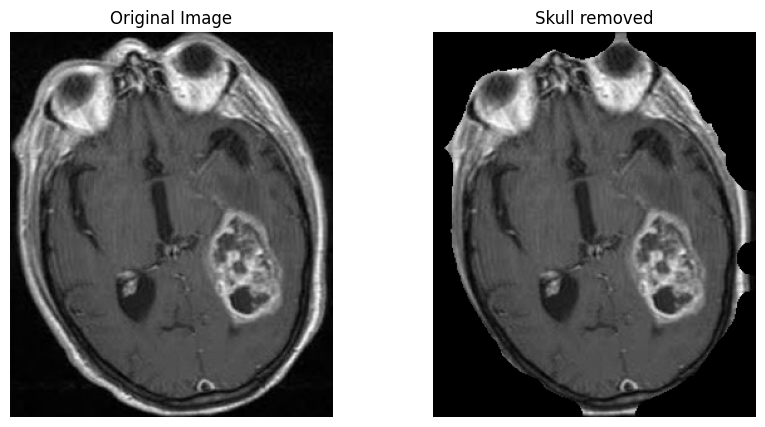

In [19]:
masked_img = cv2.bitwise_and(img, img, mask=eroded_img)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(masked_img, cmap='gray')
plt.title('Skull removed')
plt.axis('off')

plt.show()

Enhancing the image using Perona-Malik anisotropic diffusion

In [20]:
def perona_malik(img: np.ndarray, n_iter: int = 10, kappa: float = 50, gamma: float = 0.2) -> np.ndarray:
    """
    Anisotropic diffusion based on the Perona-Malik model.

    Args:
        img: The input image as a NumPy array (grayscale).
        n_iter: The number of iterations.
        kappa: The sensitivity parameter.
        gamma: The conduction parameter.

    Returns:
        The diffused image.

    Raises:
        TypeError: If input image is not a NumPy array.
        ValueError: If input image is not 2-dimensional or not of dtype float32.

    """

    if not isinstance(img, np.ndarray):
        raise TypeError("Input image must be a NumPy array.")
    if img.ndim != 2:
        raise ValueError("Input image must be 2-dimensional (grayscale).")
    
    h, w = img.shape
    img = img.astype(np.float32)

    for _ in range(n_iter):
        # Compute gradients
        grad_n = img[:-2, 1:-1] - img[1:-1, 1:-1]
        grad_s = img[2:, 1:-1] - img[1:-1, 1:-1]
        grad_e = img[1:-1, 2:] - img[1:-1, 1:-1]
        grad_w = img[1:-1, :-2] - img[1:-1, 1:-1]

        # Diffusion coefficients
        c_n = np.exp(-((grad_n / kappa) ** 2))
        c_s = np.exp(-((grad_s / kappa) ** 2))
        c_e = np.exp(-((grad_e / kappa) ** 2))
        c_w = np.exp(-((grad_w / kappa) ** 2))

        # Update image
        img[1:-1, 1:-1] += gamma * (
            c_n * grad_n + c_s * grad_s + c_e * grad_e + c_w * grad_w
        )

    return img

In [21]:
enhanced_img = perona_malik(masked_img, n_iter=20, kappa=30, gamma=0.25)

K-Means Clustering to segment the brain

In [22]:
def kmeans_segmentation(img: np.ndarray, n_clusters: int = 4) -> np.ndarray:
    """
    Performs k-means clustering for image segmentation.

    Args:
        img: The input image as a NumPy array (grayscale).
        n_clusters: The number of clusters (segments).

    Returns:
        A NumPy array representing the segmented image where each pixel value corresponds to a cluster label.
        Returns None if an error occurs during clustering.

    Raises:
        TypeError: If input image is not a NumPy array.
        ValueError: If input image is not 2-dimensional (grayscale).

    """
    if not isinstance(img, np.ndarray):
        raise TypeError("Input image must be a NumPy array.")
    if img.ndim != 2:
        raise ValueError("Input image must be 2-dimensional (grayscale).")

    try:
        height, width = img.shape
        pixel_data = img.reshape(-1, 1).astype(np.float32) #Ensure float32 for KMeans

        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10) #n_init increased for robustness
        kmeans.fit(pixel_data)
        segmented_image = kmeans.labels_.reshape(height, width)
        return segmented_image
    except Exception as e:
        print(f"An error occurred during k-means clustering: {e}")
        return None

In [23]:
segmented_img = kmeans_segmentation(enhanced_img, n_clusters=4)

Extract the tumor

In [24]:
def segment_tumor(segmented_img: np.ndarray, cluster_id: int) -> Union[np.ndarray, None]:
    """
    Extracts the tumor region from a segmented image based on a given cluster ID.

    Args:
        segmented_img: The segmented image as a NumPy array.  Each pixel value represents a cluster ID.
        cluster_id: The integer ID of the cluster representing the tumor.

    Returns:
        A binary NumPy array (mask) where 1 represents the tumor region and 0 represents the background.  
        Returns None if an error occurs or if the cluster ID is not found.

    Raises:
        TypeError: If segmented_img is not a NumPy array.
        ValueError: If cluster_id is not an integer or if segmented_img is not 2D.

    """
    if not isinstance(segmented_img, np.ndarray):
        raise TypeError("segmented_img must be a NumPy array.")
    if segmented_img.ndim != 2:
        raise ValueError("segmented_img must be a 2D array.")
    if not isinstance(cluster_id, int):
        raise ValueError("cluster_id must be an integer.")

    try:
        tumor_mask = (segmented_img == cluster_id).astype(np.uint8)
        #Check if any pixels match the cluster ID
        if np.sum(tumor_mask) == 0:
            print("Warning: No pixels found matching the specified cluster ID.")
            return None
        return tumor_mask
    except Exception as e:
        print(f"An error occurred during tumor segmentation: {e}")
        return None

In [25]:
tumor_mask = segment_tumor(segmented_img, cluster_id=2)

Displaying the final results

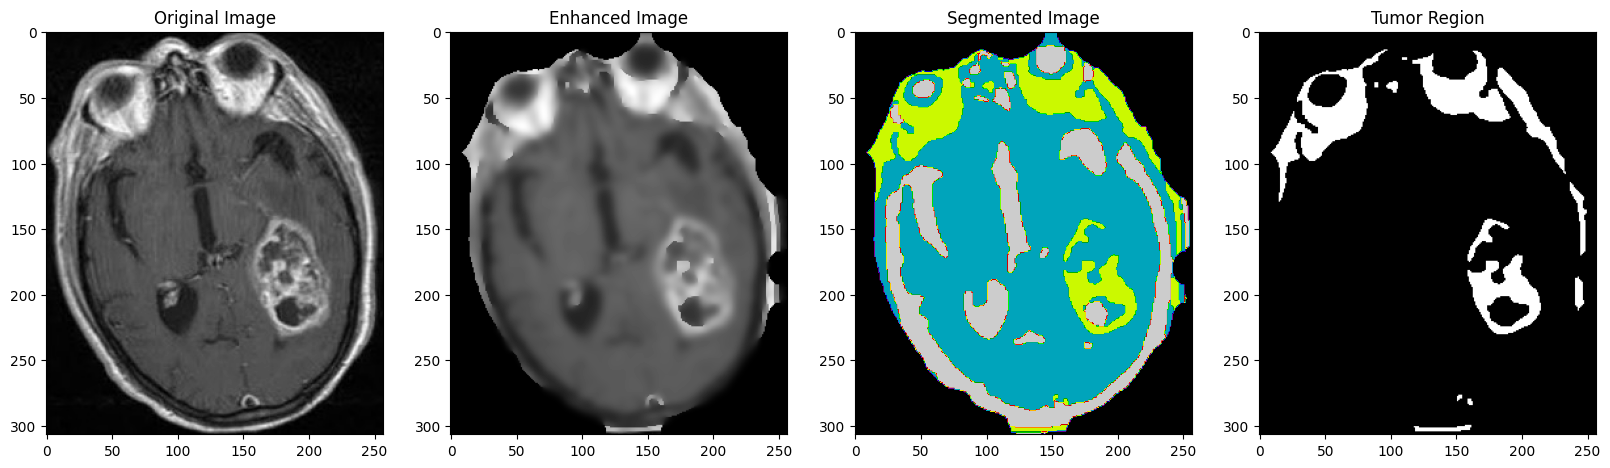

In [26]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")

plt.subplot(1, 4, 2)
plt.imshow(enhanced_img, cmap="gray")
plt.title("Enhanced Image")

plt.subplot(1, 4, 3)
plt.imshow(segmented_img, cmap="nipy_spectral")
plt.title("Segmented Image")

plt.subplot(1, 4, 4)
plt.imshow(tumor_mask, cmap="gray")
plt.title("Tumor Region")

plt.show()